## Detailed Model Evaluation

I tried to make a framework for in-depth evaluation of model predictions. I probably made some mistakes, tell me if you see any!

This is mostly just for showcasing/development; what is here is encased in functions in `metric_utils.py`. 

In [1]:
%matplotlib inline
from nl2bash import bashlint
import pandas
import numpy as np
import metric_utils
import matplotlib.pyplot as plt

Bashlint grammar set up (124 utilities)



/home/greenmon/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# reading csv file
result_path = '../../model/seq2seq/bash-T-4-birnn-gru-standard-attention-0.6-0.6-0.0-copy-1.0-128-200-1-0.0001-1e-08-0.6-0.6-0.6-0.6.normalized/predictions.beam_search.100.dev.latest.csv'
result_df = pandas.read_csv(result_path)

In [3]:
result_df.head(10) # correct template, correct command are meaningless..

,example_id,description,ground_truth,prediction,correct template,correct command
0,b'0,Adds execution permissions on a script ./etc/b...,chmod +x $(brew --prefix)/etc/bash_completion,find Path -type d -exec chmod Permission {} \\;,',NaN
1,b',NaN,NaN,find Path -type d -name Regex -exec chmod Perm...,',NaN
2,b',NaN,NaN,chmod +Permission $(find Path -type d -name Re...,',NaN
3,b',NaN,NaN,find Path -type d -exec chmod +Permission {} \\;,',NaN
4,b',NaN,NaN,find Path -type d -name Regex -exec chmod +Per...,',NaN
5,b'1,"Add prefix like number and ""^M${LOGFILE}> "" to...","nl -s""^M${LOGFILE}> """,cat File | xargs -n Quantity -I {} echo {},',NaN
6,b',NaN,NaN,nl File | xargs -n Quantity -I {} echo {},',NaN
7,b',NaN,NaN,nl -s Regex File | xargs -n Quantity -I {} ech...,',NaN
8,b',NaN,NaN,nl File | nl -s Regex | xargs -n Quantity -I {...,',NaN
9,b',NaN,NaN,nl File,',NaN


In [4]:
eval_data = []

for idx, row in result_df.iterrows():
    data_index = row.example_id[2:]
    if len(data_index) != 0:
        eval_data.append(
            metric_utils.EvalDataPoint(int(data_index))
        )
    
    if row[' description'] == row[' description']: # nan detection
        eval_data[-1].description = row[' description']
    
    if row[' ground_truth'] == row[' ground_truth']:
        eval_data[-1].gt_data.append(row[' ground_truth'])
    
    if row[' prediction'] == row[' prediction']:
        eval_data[-1].pred_data.append(row[' prediction'])

## Actual Evaluation

In [5]:
# functions from src/evaluate.py
def get_score(prediction_scores):
    score = -1.0
    if len(prediction_scores) == 0:
        return score

    has_positive_score = True in [x > 0 for x in prediction_scores]

    if has_positive_score:
        score = max(prediction_scores)
    else:
        score = sum(prediction_scores) / float(len(prediction_scores))

    return score

def compute_score(ground_truths, predicted_cmds, predicted_confds, metric_params, verbose=False):
    
    prediction_scores = []

    for grnd_truth_cmd in ground_truths:
        for i, predicted_cmd in enumerate(predicted_cmds):
            
            if predicted_cmd is None or len(predicted_cmd) == 0:
                continue
            
            predicted_confidence = predicted_confds[i]
            pair_score = metric_utils.compute_metric(predicted_cmd, predicted_confidence, grnd_truth_cmd, metric_params)
            prediction_scores.append(pair_score)

    score = get_score(prediction_scores)

    if verbose:
        print('-' * 50)
        print(f'Ground truth: {ground_truths}')
        print(f'Predictions: {predicted_cmds}')
        print(f'Prediction scores: {prediction_scores}')
        print(f'Score: {score}')

    return score

In [6]:
# single datapoint showcase
params = {
  "u1": 1.0,
  "u2": 1.0
}

def dp2score(dp, params=params, verbose=False):
    # justa a quality-of-life function
    return compute_score(dp.gt_data, dp.pred_data, [1]*len(dp.pred_data), params, verbose=verbose)

dp2score(eval_data[0], verbose=True)

--------------------------------------------------
Ground truth: ['chmod +x $(brew --prefix)/etc/bash_completion']
Predictions: ['find Path -type d -exec chmod Permission {} \\\\;', 'find Path -type d -name Regex -exec chmod Permission {} \\\\;', 'chmod +Permission $(find Path -type d -name Regex)', 'find Path -type d -exec chmod +Permission {} \\\\;', 'find Path -type d -name Regex -exec chmod +Permission {} \\\\;']
Prediction scores: [-1.0, -1.0, -1.0, -1.0, -1.0]
Score: -1.0


-1.0

In [7]:
# ok, so... we should probably filter out cases where gt marked on gt doesn't get perfect score.

# Example:
dp = eval_data[8]
compute_score(dp.gt_data, dp.gt_data, [1]*len(dp.pred_data), params, verbose=True)

--------------------------------------------------
Ground truth: ['find ./* | cpio -o > arch.cpio']
Predictions: ['find ./* | cpio -o > arch.cpio']
Prediction scores: [0.0]
Score: 0.0


0.0

In [9]:
# Filtering:
filter_func = lambda dp: compute_score(dp.gt_data, dp.gt_data, [1]*len(dp.gt_data), params) != 0.
filtered_data = list(filter(filter_func, eval_data))
print('Before filtered:', len(eval_data))
print('After filtered:', len(filtered_data))

Before filtered: 699
After filtered: 503


In [10]:
# calculating scores takes some time actually
all_scores = list(map(dp2score, filtered_data))

In [11]:
# filtering by score showcase
threshold = 0.0
with open(f'BadCases_{threshold}.txt', 'w') as f:
    for score, dp in zip(all_scores, filtered_data):
        if score < threshold:
            print(f'----- ID: {dp.index} -----', file=f)
            print(f'NLC:', file=f)
            print(dp.description, file=f)
            print(f'GT(s):', file=f)
            print('\n'.join(dp.gt_data), file=f)
            print(f'Predictions:', file=f)
            print('\n'.join(dp.pred_data), file=f)
            print(f'Score: {score}', file=f)

Total: 503
Average: 0.2648604208084824
Median: 0.5
Number of perfect scores: 202
Number of completely wrong: 53
Positive scores: 319
Sub-zero scores: 182
Number of balanced: 3


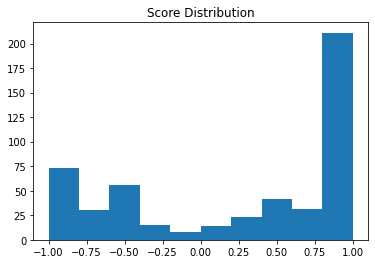

In [12]:
# score distribution showcase

n_by_bin, _, _ = plt.hist(all_scores)
plt.title('Score Distribution')

print('Total:', len(all_scores))
print('Average:', np.mean(all_scores))
print('Median:', np.median(all_scores))
print('Number of perfect scores:', len([e for e in all_scores if 1-e<1e-4]))
print('Number of completely wrong:', len([e for e in all_scores if e+1<1e-4]))
print('Positive scores:', len([e for e in all_scores if e > 0]))
print('Sub-zero scores:', len([e for e in all_scores if e < 0]))
print('Number of balanced:', len([e for e in all_scores if abs(e)<1e-4]))

In [13]:
# util accuracy
def compute_uacc(ground_truths, predicted_cmds, verbose=False):
    prediction_scores = []
    for grnd_truth_cmd in ground_truths:
        for i, predicted_cmd in enumerate(predicted_cmds):
            if predicted_cmd is None or len(predicted_cmd) == 0:
                continue
            pair_score = metric_utils.compute_util_acc(predicted_cmd, grnd_truth_cmd)
            prediction_scores.append(pair_score)
    score = get_score(prediction_scores)

    if verbose:
        print('-' * 50)
        print(f'Ground truth: {ground_truths}')
        print(f'Predictions: {predicted_cmds}')
        print(f'Prediction scores: {prediction_scores}')
        print(f'Score: {score}')

    return score

In [14]:
import importlib
importlib.reload(metric_utils)

<module 'metric_utils' from '/home/greenmon/Projects/nlc2cmd/clai/submission-code/src/submission_code/nlc2cmd/nl2bash/eval/score_eval/metric_utils.py'>

In [15]:
uacc_mapper = lambda dp: compute_uacc(dp.gt_data, dp.pred_data)
all_uaccs = list(map(uacc_mapper, filtered_data))

0.7668749408312032


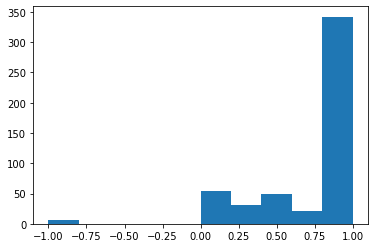

In [16]:
plt.hist(all_uaccs) # negative exists because of no-answer scenarios, can be ignored
print(np.mean(all_uaccs))

In [17]:
# Where are we losing points, utility or flag?
def get_loss(ulosses, flosses):
    score = -1.0
    if len(ulosses) == 0:
        return (2, 0)

    best_index = np.argmin(np.array(ulosses) + np.array(flosses))
    return ulosses[best_index], flosses[best_index]

def compute_loss(ground_truths, predicted_cmds, predicted_confds, metric_params, verbose=False):
    
    ulosses = []
    flosses = []

    for grnd_truth_cmd in ground_truths:
        for i, predicted_cmd in enumerate(predicted_cmds):
            
            if predicted_cmd is None or len(predicted_cmd) == 0:
                continue
            
            predicted_confidence = predicted_confds[i]
            uloss, floss = metric_utils.compute_metric_loss(predicted_cmd, predicted_confidence, grnd_truth_cmd, metric_params)
            ulosses.append(uloss)
            flosses.append(floss)

    best_uloss, best_floss = get_loss(ulosses, flosses)

    if verbose:
        print('-' * 50)
        print(f'Ground truth: {ground_truths}')
        print(f'Predictions: {predicted_cmds}')
        print(ulosses, flosses)
        print(f'Utility loss: {best_uloss}')
        print(f'Flag loss: {best_floss}')

    return best_uloss, best_floss

def dp2loss(dp, params=params, verbose=False):
    # justa a quality-of-life function
    return compute_loss(dp.gt_data, dp.pred_data, [1]*len(dp.pred_data), params, verbose=verbose)

In [18]:
dp2score(filtered_data[0], verbose=True)

--------------------------------------------------
Ground truth: ['nl -s"^M${LOGFILE}>  "']
Predictions: ['cat File | xargs -n Quantity -I {} echo {}', 'nl File | xargs -n Quantity -I {} echo {}', 'nl -s Regex File | xargs -n Quantity -I {} echo {}', 'nl File | nl -s Regex | xargs -n Quantity -I {} echo {}', 'nl File']
Prediction scores: [-1.0, -0.6666666666666666, -0.3333333333333333, -0.75, 0.0]
Score: -0.55


-0.55

In [19]:
dp2loss(filtered_data[0], verbose=True)

--------------------------------------------------
Ground truth: ['nl -s"^M${LOGFILE}>  "']
Predictions: ['cat File | xargs -n Quantity -I {} echo {}', 'nl File | xargs -n Quantity -I {} echo {}', 'nl -s Regex File | xargs -n Quantity -I {} echo {}', 'nl File | nl -s Regex | xargs -n Quantity -I {} echo {}', 'nl File']
[2.0, 1.3333333333333333, 1.3333333333333333, 1.5, 0.0] [0.0, 0.3333333333333333, 0.0, 0.25, 1.0]
Utility loss: 0.0
Flag loss: 1.0


(0.0, 1.0)

In [20]:
fineloss_mapper = lambda dp: compute_loss(dp.gt_data, dp.pred_data, [1]*len(dp.pred_data), params)
all_losses = list(map(fineloss_mapper, filtered_data))

In [21]:
util_loss, flag_loss = zip(*all_losses)

Mean Util Loss: 0.44371864053772603
Mean Flag Loss: 0.2194369497301903


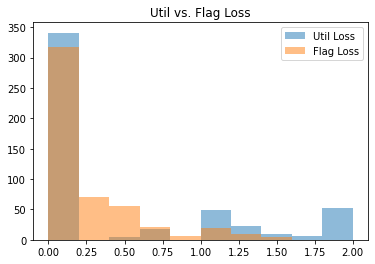

In [22]:
plt.hist(util_loss, alpha=0.5, range=(0, 2), label="Util Loss")
plt.hist(flag_loss, alpha=0.5, range=(0, 2), label="Flag Loss")
plt.title('Util vs. Flag Loss')
plt.legend()

print(f'Mean Util Loss:', np.mean(util_loss))
print(f'Mean Flag Loss:', np.mean(flag_loss))

### Fun

In [23]:
super_filter = lambda dp: len(dp.gt_data) > 0 #'find' in dp.gt_data[0]
fun_data = list(filter(super_filter, filtered_data))
fun_scores = list(map(dp2score, fun_data))

Text(0, 0.5, 'Final Score')

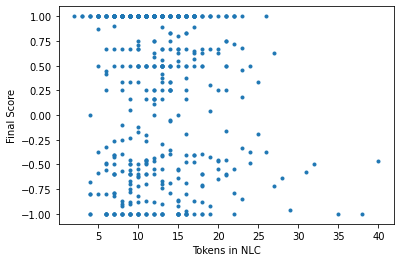

In [24]:
fdata_len = [len(dp.description.split()) for dp in fun_data]
plt.plot(fdata_len, fun_scores, '.')
plt.xlabel('Tokens in NLC')
plt.ylabel('Final Score')
# no discernable correlation...

Text(0, 0.5, 'Final Score')

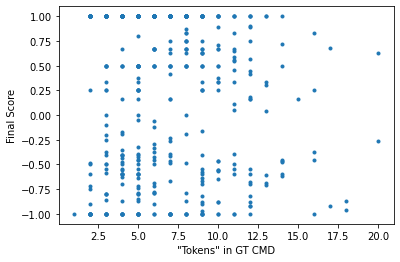

In [25]:
fdata_cmlen = [len(dp.gt_data[0].split()) for dp in fun_data if len(dp.gt_data) > 0]
plt.plot(fdata_cmlen, fun_scores, '.')
plt.xlabel('"Tokens" in GT CMD')
plt.ylabel('Final Score')

In [26]:
sns.jointplot(x=fdata_len, y=fun_scores, kind="hex")

NameError: name 'sns' is not defined

2 score groups: difficult, easy

In [ ]:
# hello

import seaborn as snsx